In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
X_Ray_Directory= '/content/drive/MyDrive/Data+Science+for+Business+Package/Data Science for Business Package/4. Operations Department/Dataset'

In [ ]:
os.listdir(X_Ray_Directory)

['3', '0', '1', '2']

In [ ]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory= X_Ray_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')

Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory= X_Ray_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='validation')

Found 104 images belonging to 4 classes.


In [ ]:
# Generating the batch of 40 images and labels
train_images, train_labels= next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
# There are four classes: Healthy, Covid-19, Bacterial Pneumonia, Viral Pneumonia
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]],

In [ ]:
# Label translator
label_name= {0: 'Covid-19', 1: 'Healthy', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

## Visualizing the data

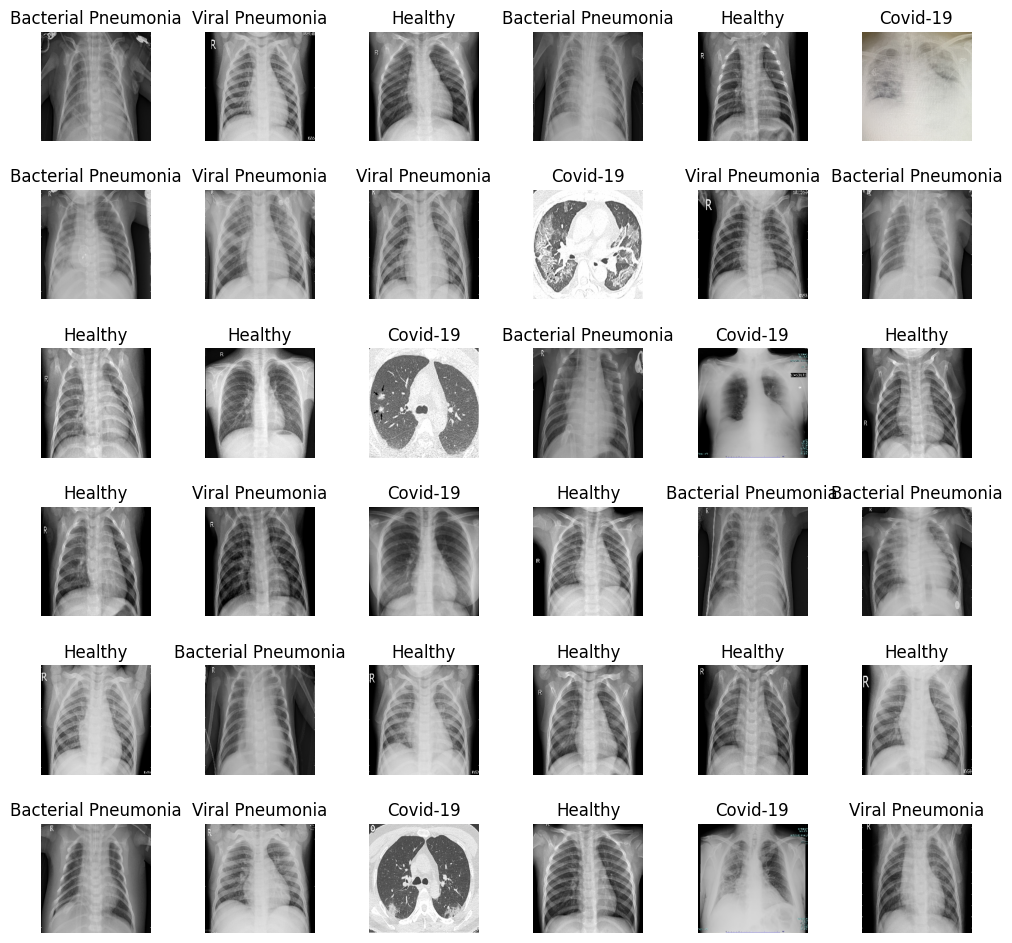

In [ ]:
L =6
W = 6
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()
for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_name[np.argmax(train_labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [ ]:
# Convolution --> convolution layer--> Pooling Layer --> Flatten --> Find the category of the image
# We are using pretrained models here to do transfer learning
basemodel = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Freezing layers in the model and taking last 10 layers
for layer in basemodel.layers[:-10]:
  layer.trainable = False

## Build and Train Deep Learning Model

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel= Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation= 'softmax')(headmodel)

In [ ]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss= 'categorical_crossentropy', optimizer= optimizers.RMSprop(learning_rate= 1e-4), metrics=['accuracy'])

In [ ]:
# using early stopping to exit training id validation loss is not decreasing after certain epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
# Save the best model with lower validation loss

checkpointer = ModelCheckpoint(filepath= 'weights.keras', verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=4,
                                                      directory= X_Ray_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4,
                                                      directory= X_Ray_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[checkpointer, early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3075 - loss: 1.6063
Epoch 1: val_loss improved from inf to 1.40891, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.3080 - loss: 1.6047 - val_accuracy: 0.2500 - val_loss: 1.4089
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4554 - loss: 1.1342
Epoch 2: val_loss improved from 1.40891 to 1.08656, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.4560 - loss: 1.1338 - val_accuracy: 0.4519 - val_loss: 1.0866
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5943 - loss: 1.0235
Epoch 3: val_loss improved from 1.08656 to 0.97359, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.5947 - loss: 1.0226 - val_accuracy: 0.5000 - val_loss: 0.9736
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6299 - loss: 0.8814
Epoch 4: val_loss did not improve from 0.97359
107/107 ━━━━━━━━━━━━━━━━━━━━

## Evaluate trained deep learning model

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

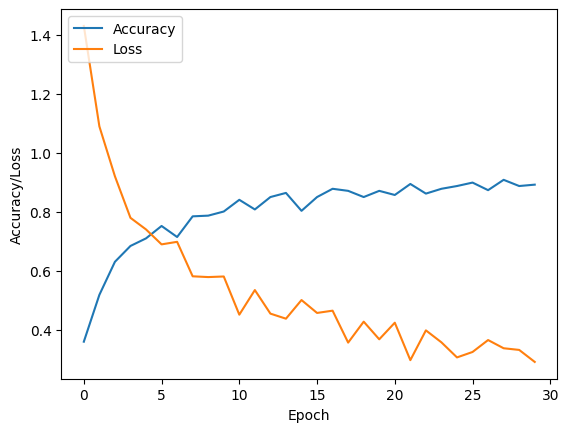

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(['Accuracy', 'Loss'], loc='upper left')

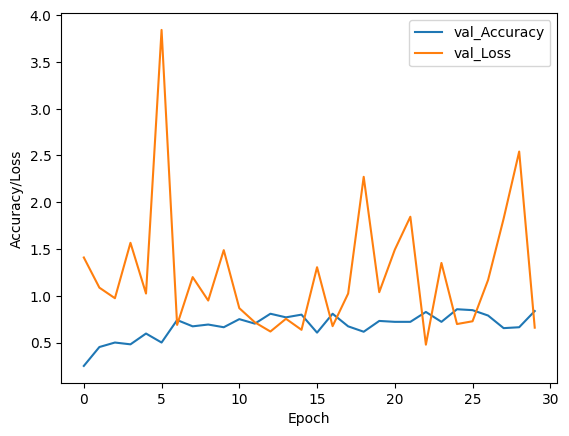

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(['val_Accuracy', 'val_Loss'], loc='upper right')

In [ ]:
test_directory = '/content/drive/MyDrive/Data+Science+for+Business+Package/Data Science for Business Package/4. Operations Department/Test'

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=4,
                                                      directory= test_directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode='categorical')

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate(test_generator, steps= test_generator.n//4, verbose=1)
print('Accuracy: {:.2f}'.format(evaluate[1]))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8203 - loss: 1.2919
Accuracy: 0.80


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

prediction = []
original = []
image= []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img/255
    img = img.reshape(-1, 256, 256, 3)
    pred = model.predict(img)
    pred = np.argmax(pred)
    prediction.append(pred)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
score = accuracy_score(original, prediction)
print('Accuracy: {:.2f}'.format(score))

Accuracy: 0.80


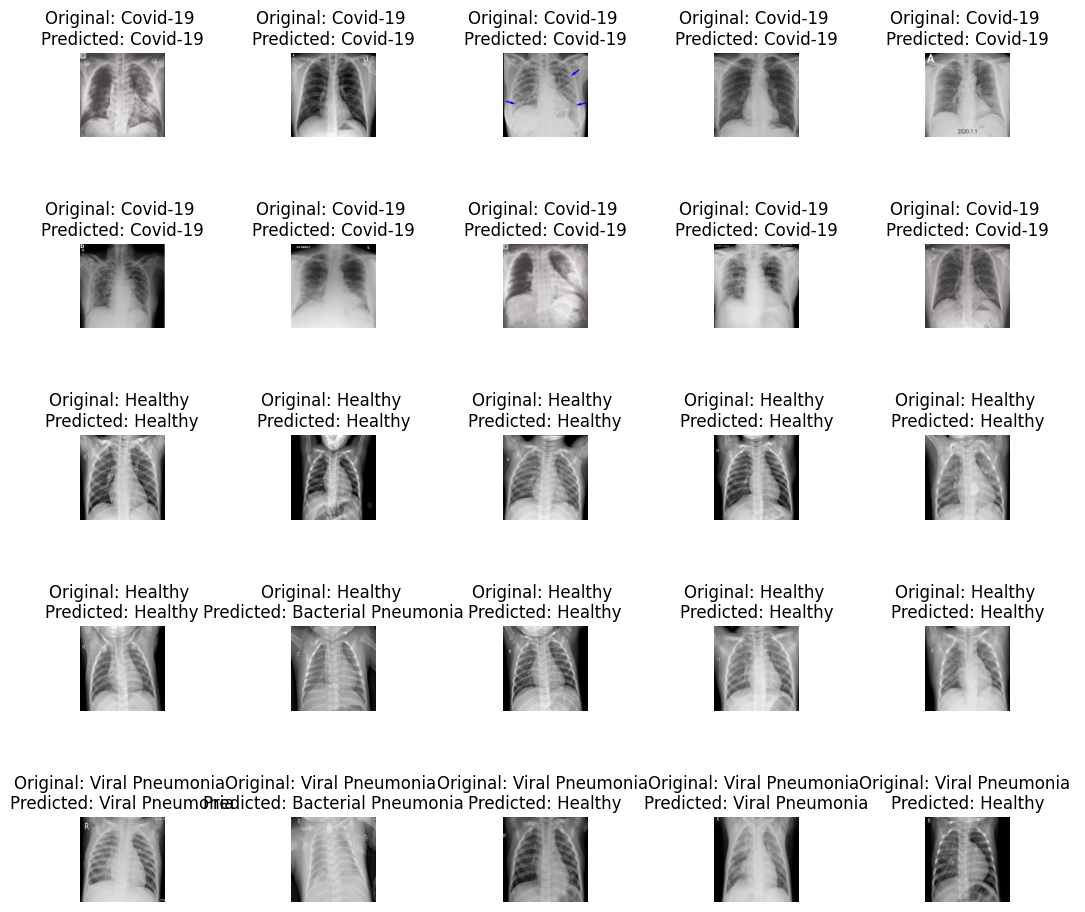

In [ ]:
L =5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(image[i])
  axes[i].set_title('Original: ' + str(label_name[original[i]]) + ' \nPredicted: ' + str(label_name[prediction[i]]))
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.5)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.69      0.90      0.78        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.80        40
   macro avg       0.83      0.80      0.79        40
weighted avg       0.83      0.80      0.79        40



[Text(0, 0.5, 'Covid-19'),
 Text(0, 1.5, 'Healthy'),
 Text(0, 2.5, 'Viral Pneumonia'),
 Text(0, 3.5, 'Bacterial Pneumonia')]

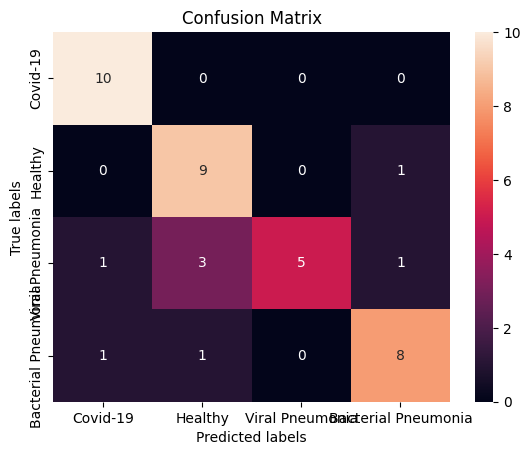

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Covid-19', 'Healthy', 'Viral Pneumonia', 'Bacterial Pneumonia'])
ax.yaxis.set_ticklabels(['Covid-19', 'Healthy', 'Viral Pneumonia', 'Bacterial Pneumonia'])